# ETF Pipeline2 using s3

> Gradually bringing in over stuff from first pipeline. ETF flow decompositions pipeline but querying data from arcticdb.
- skip_exec: true

In [1]:
# | hide
# | eval: false
%load_ext autoreload
%autoreload 2

In [2]:
# | default_exp etf_pipeline_s3

In [3]:
# | hide
from nbdev.showdoc import *

In [4]:
# | export
import os

import click
from arcticdb import Arctic, QueryBuilder
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from pathlib import Path
from lobster_tools.config import MainConfig, Overrides, register_configs, get_config, NASDAQExchange
from lobster_tools.preprocessing import *
from lobster_tools.querying import *
from lobster_tools.flow_decomposition import *
from lobster_tools.config import etf_to_equities
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from itertools import product
import datetime as dt
from dataclasses import dataclass
from functools import partial
import json
from typing import Literal, cast
import numpy as np
from pprint import pprint
from collections import namedtuple
import matplotlib.pyplot as plt
import itertools as it
import statsmodels.api as sm

In [5]:
import arcticdb

In [6]:
# | eval: false
register_configs()
cfg = get_config(overrides=Overrides.full_server)

In [7]:
# | eval: false
directory_path = cfg.data_config.csv_files_path
etfs = cfg.universe.etfs
equities = cfg.universe.equities

markouts = cfg.hyperparameters.markouts
finest_resample = cfg.hyperparameters.finest_resample
max_markout = cfg.hyperparameters.max_markout

date_range = dt.date(2021, 1, 6), dt.datetime(2021, 1, 6, 16, 0)

In [8]:
# | eval: false
# temp 
etfs = ['SPY']
equities = etf_to_equities['SPY']
tolerances = ["250us", "500us"]
markouts = ["30S", "1min", "2min", "4min"]
finest_resample = "30S"
max_markout = "4min"
dates = NASDAQExchange().trading_days

### Equity data

In [9]:
# | eval: false
# connect to database
arctic = Arctic('s3://163.1.179.45:9100:lobster?access=minioadmin&secret=minioadmin')
arctic.list_libraries()
arctic_library = arctic["2021"]

In [10]:
arctic.list_libraries()

['2021', 'demo', 'testa']

In [11]:
arctic_library.list_symbols()

['PBCT',
 'COO',
 'HCA',
 'LIN',
 'IRM',
 'ALXN',
 'AMG',
 'VRTX',
 'WRK',
 'UAA',
 'EQR',
 'HES',
 'RHI',
 'EMN',
 'ISRG',
 'PEAK',
 'WMT',
 'ROST',
 'ZION',
 'PFE',
 'INTC',
 'AWK',
 'ILMN',
 'NOC',
 'ADBE',
 'NEM',
 'TEL',
 'GPN',
 'XLE',
 'DTE',
 'FOXA',
 'MMM',
 'ODFL',
 'DISCA',
 'UA',
 'CE',
 'AIG',
 'WDC',
 'LKQ',
 'AON',
 'OXY',
 'FOX',
 'BIIB',
 'WLTW',
 'DVA',
 'DD',
 'PFG',
 'WRB',
 'MA',
 'WBA',
 'SLB',
 'LHX',
 'ADSK',
 'ROK',
 'EXC',
 'NWS',
 'VIAC',
 'L',
 'APH',
 'FCX',
 'UDR',
 'ULTA',
 'MLM',
 'GL',
 'MTD',
 'EL',
 'APA',
 'SCHW',
 'BSX',
 'MCO',
 'ANET',
 'PGR',
 'BR',
 'SPGI',
 'NTRS',
 'CI',
 'SWKS',
 'LEN',
 'GPS',
 'KIM',
 'ADM',
 'FFIV',
 'LW',
 'CMCSA',
 'PKG',
 'ED',
 'NOW',
 'SHW',
 'AVGO',
 'ALLE',
 'AMT',
 'BLL',
 'CFG',
 'MMC',
 'AMZN',
 'LEG',
 'LYB',
 'EXPE',
 'FANG',
 'TMO',
 'MSCI',
 'GM',
 'ABC',
 'JBHT',
 'ZBH',
 'CAG',
 'JNJ',
 'PNR',
 'FTI',
 'IEX',
 'COTY',
 'J',
 'SLG',
 'FAST',
 'AMP',
 'HAL',
 'ALK',
 'AEP',
 'GOOG',
 'HPE',
 'NWL',
 'DHR',
 '

In [12]:
'FLIR' in  arctic_library.list_symbols()

True

In [13]:
df = arctic_library.read(symbol="FLIR").data

In [14]:
df

,time,event,order_id,size,price,direction,ask_price_1,ask_size_1,bid_price_1,bid_size_1,...,bid_price_8,bid_size_8,ask_price_9,ask_size_9,bid_price_9,bid_size_9,ask_price_10,ask_size_10,bid_price_10,bid_size_10
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:00.082945826,34200.082946,6,-1,114046,53.04,0,53.40,30.0,53.00,102.0,...,52.12,20.0,53.98,100.0,52.06,30.0,54.00,114.0,52.0,1702.0
2021-01-04 09:30:00.082945826,34200.082946,1,5746542,100,53.00,1,53.40,30.0,53.00,202.0,...,52.12,20.0,53.98,100.0,52.06,30.0,54.00,114.0,52.0,1702.0
2021-01-04 09:30:00.082945826,34200.082946,1,5947466,30,53.05,-1,53.05,30.0,53.00,202.0,...,52.12,20.0,53.97,200.0,52.06,30.0,53.98,100.0,52.0,1702.0
2021-01-04 09:30:00.082945826,34200.082946,1,6468306,4,53.00,1,53.05,30.0,53.00,206.0,...,52.12,20.0,53.97,200.0,52.06,30.0,53.98,100.0,52.0,1702.0
2021-01-04 09:30:00.082945826,34200.082946,1,9140546,15,53.35,-1,53.05,30.0,53.00,206.0,...,52.12,20.0,53.95,100.0,52.06,30.0,53.97,200.0,52.0,1702.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14 15:58:56.101129951,57536.101130,1,602400738,100,57.35,1,47.02,161.0,67.66,168.0,...,57.12,1.0,59.73,130.0,57.10,9.0,59.85,1.0,57.0,1.0
2021-05-14 15:59:00.079192839,57540.079193,3,591351810,1,57.35,1,47.02,161.0,67.66,168.0,...,57.12,1.0,59.73,130.0,57.10,9.0,59.85,1.0,57.0,1.0
2021-05-14 15:59:25.478780181,57565.478780,3,159541482,10,59.34,-1,47.02,161.0,67.66,168.0,...,57.12,1.0,59.85,1.0,57.10,9.0,59.99,5.0,57.0,1.0


In [ ]:
# | eval: false
all_symbols = arctic["2021"].list_symbols()
equities = list(set(equities).intersection(all_symbols))

In [6]:
# | eval: false
def get_trading_days(df):
    return df.groupby(df.index.date).first().index

In [7]:
# | eval: false
def read_single_ticker_executions(ticker, date_range = None):
    """Read executions from database for single ticker."""

    columns = [
        "time",
        "event",
        "order_id",
        "size",
        "price",
        "direction",
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    return df

In [8]:
# | eval: false
def read_multiple_tickers_executions(tickers, date_range = None):
    """Multiple version of `read_single_ticker_executions`."""
    return pd.concat(
        read_single_ticker_executions(ticker, date_range) for ticker in tickers 
    ).sort_index().astype({"ticker": "category"})

In [9]:
# | eval: false
def date_to_tuple(date: dt.date):
    end_of_trading = dt.time(hour=16)
    return (date, dt.datetime.combine(date, end_of_trading))

def get_datetime_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = [x.date() for x in dates]
    date_tuples = [date_to_tuple(x) for x in dates]
    return date_tuples

def timestamp_to_tuple(timestamp):
    end_of_trading_day = pd.Timedelta(hours=16)
    # could also return datetimes with .to_pydatetime
    return (timestamp, timestamp + end_of_trading_day)

def get_timestamp_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    date_tuples = [timestamp_to_tuple(x) for x in dates]
    return date_tuples

One day

In [9]:
# | eval: false
def get_mids_for_etf(ticker, date_range):
    """Get only mids at a specified resample frequency."""
    columns = [
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    resampled_mid = df.mid.resample('30S', label='right', closed='left').last()
    return df, resampled_mid

In [10]:
# | eval: false
def markout_to_int(markout: str, finest_resample: str = "30S"):
    """Maybe add stuff where checks this is almost an int"""
    ratio = pd.Timedelta(markout) / pd.Timedelta(finest_resample)
    if np.isclose(ratio, np.round(ratio), atol=1e-4):
        return int(np.round(ratio))
    else:
        ValueError("Markouts must be multiples of finest resample frequency")

markout_to_int("1min")

2

In [126]:
# import numpy as np
# import pandas as pd

# np.random.seed(0)

# prices = np.random.uniform(low=0, high=100, size=100)
# price_series = pd.Series(prices)

# print(price_series)

# price_series.shift(-1) - price_series

0     54.881350
1     71.518937
2     60.276338
3     54.488318
4     42.365480
        ...    
95    18.319136
96    58.651293
97     2.010755
98    82.894003
99     0.469548
Length: 100, dtype: float64


In [13]:
# | eval: false
def compute_log_returns(mid):
    """Compute mid price dataframe at various markouts and compute log returns for those markouts"""
    df = pd.DataFrame(mid)
    markouts_str = ["30S", "1min", "2min"]

    Markout = namedtuple('Markout', ['str','int'])
    markouts = [Markout(x, markout_to_int(x)) for x in markouts_str]
    for markout in markouts:
        df[f"_{markout.str}"] = df.mid.shift(-markout.int)
    
    df = df.resample('5min', label='right', closed='right').last()

    # not sure how to drop all resampled buckets where there was a NaN before
    # for now simply drop last row of resampled dataframe
    df = df.iloc[:-1]

    # now compute log returns
    # markout_columns = df.filter(regex="^_").columns.to_list()
    markout_columns = [f"_{markout.str}" for markout in markouts]
    
    log_returns = np.log(df[markout_columns].divide(df.mid, axis=0))

    # is it better to take differences? this feels like it should be better but doesn't run
    # print('hi')
    # breakpoint()
    # log_returns = np.log(df[markout_columns]) - np.log(df.mid)

    # markout_to_int(resample_freq)
    contemp_log_returns = np.log(df.mid) - np.log(df.mid.shift(1))
    log_returns["contemp"] = contemp_log_returns

    # NOTE: better way to do this?
    # resampling goes through non trading periods
    log_returns.dropna(inplace=True)
    return log_returns

In [14]:
# | eval: false
def compute_ofi(df):
    """Compute ofi. Times are right stamped in that you know the ofi at that time.

    Closed is left here as it is unlikely to have a stamp exactly on the dot.
    """
    ofi = (
        df[["size", "direction"]]
        .eval("signed_size = size * direction")
        .drop(columns=['direction'])
        .resample(resample_freq, label="right", closed="left")
        .sum()
        .between_time('09:29', '16:01')
        .eval('ofi = signed_size / size')
        .ofi
        .fillna(0)
    )
    return ofi

In [15]:
# | eval: false
def run_regressions(X, Y):
    model = MultiOutputRegressor(LinearRegression(fit_intercept=False)).fit(X, Y)

    results = []
    for col, estimator in zip(Y.columns, model.estimators_):
        results.append({
            'target_markout': col,
            'r2': estimator.score(X, Y[col]),
            'coef': estimator.coef_,
            'intercept': estimator.intercept_
        })

    results_df = pd.DataFrame(results).set_index('target_markout')
    return results_df

In [16]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(regex="^_").notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics

In [20]:
df.columns

Index(['time', 'event', 'order_id', 'size', 'price', 'direction',
       'ask_price_1', 'bid_price_1', 'ticker', 'mid', '_250us_neighbors',
       '_500us_neighbors', '_250us_distinct_tickers_ss_bf',
       '_250us_distinct_tickers_ss_af', '_250us_distinct_tickers_os_bf',
       '_250us_distinct_tickers_os_af', '_250us_notional_ss_bf',
       '_250us_notional_ss_af', '_250us_notional_os_bf',
       '_250us_notional_os_af', '_250us_num_trades_ss_bf',
       '_250us_num_trades_ss_af', '_250us_num_trades_os_bf',
       '_250us_num_trades_os_af', '_500us_distinct_tickers_ss_bf',
       '_500us_distinct_tickers_ss_af', '_500us_distinct_tickers_os_bf',
       '_500us_distinct_tickers_os_af', '_500us_notional_ss_bf',
       '_500us_notional_ss_af', '_500us_notional_os_bf',
       '_500us_notional_os_af', '_500us_num_trades_ss_bf',
       '_500us_num_trades_ss_af', '_500us_num_trades_os_bf',
       '_500us_num_trades_os_af', 'pnl_to_close', 'hit_ratio'],
      dtype='object')

In [17]:
# | export
def quick_marginalize(df: pd.DataFrame) -> pd.DataFrame:
    """Manual implementation but for all features."""
    df = df.copy()
    # NOTE: tmp hardcoded feature names, change this to a regexp
    # will just grab these from globals and not set in function.
    tolerances = ['250us', '500us']
    features = ['num_trades', 'notional', 'distinct_tickers']
    col_names = ["_" + "_".join(x) for x in it.product(tolerances, features)]

    for col_name in col_names:
        # marginalise over all
        df[col_name] = df[col_name + "_ss_af"] + df[col_name + "_ss_bf"] + df[col_name + "_os_af"] + df[col_name + "_os_bf"]
        # marginalise over bf/af
        df[col_name + "_ss"] = df[col_name + "_ss_af"] + df[col_name + "_ss_bf"]
        df[col_name + "_os"] = df[col_name + "_os_af"] + df[col_name + "_os_bf"]
        # marginalise over ss/os
        df[col_name + "_af"] = df[col_name + "_ss_af"] + df[col_name + "_os_af"]
        df[col_name + "_bf"] = df[col_name + "_ss_bf"] + df[col_name + "_os_bf"]

    return df

In [ ]:
# | export
def marginalize(df: pd.DataFrame) -> pd.DataFrame:
    """Quick implentation just for one feature. Just for _500us!"""
    # TODO think whether inplace is better
    df = df.copy()
    df["_500us_num_trades"] = df._500us_num_trades_os_af + df._500us_num_trades_os_bf + df._500us_num_trades_ss_af + df._500us_num_trades_ss_bf
    # same for others...
    return df

In [18]:
# | eval: false
def sparse_to_dense(df):
    """Convert all sparse columns to dense."""
    sparse_columns = [col for col in df.columns if isinstance(df[col].dtype, pd.SparseDtype)]
    df[sparse_columns] = df[sparse_columns].sparse.to_dense()
    return df

In [18]:
# | eval: false
def keep_bins(s: pd.Series):
    value_counts = s.value_counts().sort_index()
    CUTOFF = 50
    not_enough_data = value_counts < CUTOFF
    up_to = not_enough_data.idxmax()
    return up_to

In [14]:
# | eval: false
def add_pnl_columns(df):
    df = df.copy(deep=True)
    CLOSE_PRICE = ( df.query("direction == 1").iloc[-1].price + df.query("direction == -1").iloc[-1].price ) / 2
    df = df.assign(pnl_to_close_bps = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction,
              hit_ratio = lambda df_: ((df_.pnl_to_close_bps) > 0))
    return df

## PoolProcess for many dates

In [ ]:
# | eval: false
def dump_to_pickle(date):
    "This is not useful..right?"
    print(etfs)
    print(equities)
    equity_executions=read_multiple_tickers_executions(tickers=equities, date_range=date)
    etf_executions=read_multiple_tickers_executions(tickers=etfs, date_range=date)

    etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerances=tolerances)
    etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)
    etf_executions_features_pnl = add_pnl_columns(etf_executions_features)

    # for now just one etf

    # if want to pickle
    # assert len(etfs) == 1
    # etf_name = etfs[0]
    date_str = dt.datetime.combine(date[0], dt.datetime.min.time()).strftime("%Y-%m-%d")
    # etf_executions_features_pnl.to_pickle(f"../features/{etf_name}_{date_str}")
    print(f"done {date_str}")
    return etf_executions_features_pnl

In [ ]:
# | eval: false
def filter_to_existing_equities(equities):
    existing_symbols = arctic_library.list_symbols() 
    return list(set(equities).intersection(set(existing_symbols)))

equities = filter_to_existing_equities(equities)
print(equities)

In [ ]:
# | eval: false
from concurrent.futures import ProcessPoolExecutor, wait, as_completed
dates = NASDAQExchange().trading_days
dates = dates
dates = [date_to_tuple(x) for x in dates]
dates = dates[:70]

with ProcessPoolExecutor(max_workers=70) as executor:
    dfs = list(executor.map(dump_to_pickle, dates))

df = pd.concat(dfs)
df.to_pickle('../features/SPY_all_10')

In [ ]:
df.to_pickle("../features/XLC_all")

In [ ]:
returns = compute_log_returns(df.mid)
returns

In [ ]:
compute_ofi(df)

In [ ]:
X = compute_ofi(df)
Y = compute_log_returns(df.mid)
Y = Y.fillna(0)
X, Y = restrict_common_index(X, Y)

run_regressions(X,Y)

### Load with ArcticDB

In [ ]:
# | eval: false
closing_prices = df.resample('D').transform('last').price

In [ ]:
# | eval: false
df["closing_price"] = closing_prices

In [ ]:
# | eval: false
df.eval("pnl_to_close = (closing_price - price) * 1e4 * direction", inplace=True)
df.eval("hit_ratio = (pnl_to_close > 0)", inplace=True)

In [ ]:
# | eval: false
summary_statistics = df.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

In [ ]:
# | eval: false
%store etf_executions_neighbors
%store etf_executions_features

In [ ]:
%store -r

### Data analysis

In [19]:
df = pd.read_pickle('../features/XLC_all')
# df = df.rename(columns={'pnl_to_close':'pnl_to_close_bps', 'hit_ratio':'hit'})

In [20]:
df = sparse_to_dense(df)

In [21]:
df = quick_marginalize(df)

<Axes: >

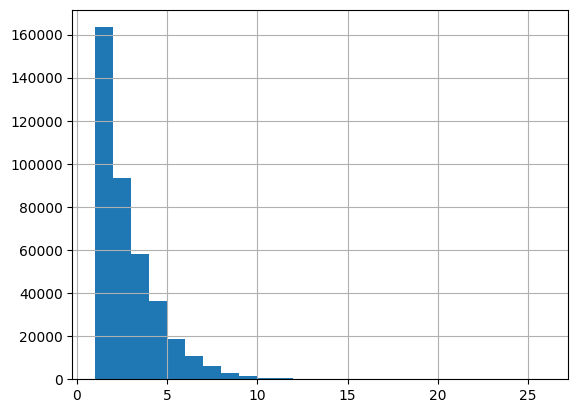

In [22]:
df._500us_distinct_tickers[df._500us_distinct_tickers != 0].hist(bins=25)

In [23]:
def add_decile_tags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy(deep=True)
    feature_columns = [col for col in df.columns if (col.startswith('_') and ('neighbors' not in col))]

    for col in feature_columns:
        df[col + '_decile'] = 0
        mask = (df[col] != 0)
        df.loc[mask, col + '_decile'] = 1 + pd.qcut(df.loc[mask, col], 10, labels=False, duplicates='drop')

    return df

In [24]:
df = add_decile_tags(df)

<Axes: >

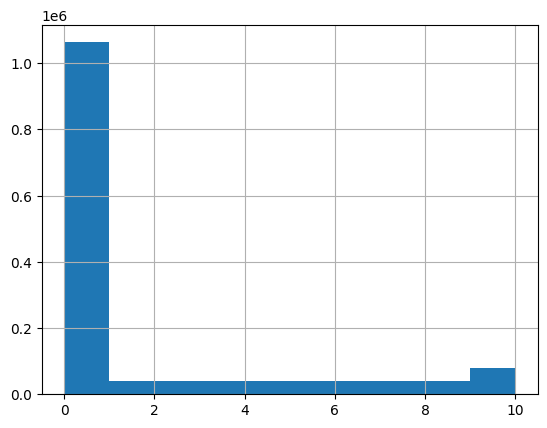

In [25]:
df._500us_notional_decile.hist()

In [26]:
def pnl_groupby_summaries(df: pd.DataFrame) -> None:
    decile_columns = df.filter(regex="decile")
    for feature in decile_columns:
        display(df.groupby(feature).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean")))

In [27]:
pnl_groupby_summaries(df)

,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_ss_bf_decile,,,
0,-0.643133,61.770854,0.492517
1,-0.812760,61.355928,0.488561
2,-4.045905,56.422537,0.475604


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_ss_af_decile,,,
0,-0.558275,61.898632,0.493068
1,-1.550585,60.343574,0.483882
2,-3.307661,53.813348,0.465782


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_os_bf_decile,,,
0,-0.865763,61.721163,0.490340
1,3.411774,61.212043,0.526734
2,1.061222,48.415640,0.528889


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_os_af_decile,,,
0,-0.800908,61.803316,0.490813
1,2.242885,58.917906,0.519649
2,6.493440,62.372479,0.521565


,ppt_mean,ppt_std,hit_ratio
_250us_notional_ss_bf_decile,,,
0,-0.643133,61.770854,0.492517
1,-1.607361,58.570349,0.485398
2,-0.202579,60.670307,0.491769
3,0.459644,62.920067,0.494993
4,-0.878494,59.112991,0.489934
5,0.524772,60.142107,0.498243
6,-0.307312,60.133286,0.492372
7,-1.883595,60.466047,0.484558
8,-0.396542,63.332272,0.497536


,ppt_mean,ppt_std,hit_ratio
_250us_notional_ss_af_decile,,,
0,-0.558275,61.898632,0.493068
1,-2.834461,59.781180,0.479300
2,-1.676672,59.687747,0.492979
3,-0.519953,62.552460,0.487992
4,-1.882139,59.100325,0.485865
5,0.651685,58.987017,0.502371
6,-1.792374,60.077847,0.489332
7,-1.196554,60.304223,0.485316
8,-1.320801,58.007007,0.473067


,ppt_mean,ppt_std,hit_ratio
_250us_notional_os_bf_decile,,,
0,-0.865763,61.721163,0.490340
1,1.879327,59.058280,0.528149
2,-1.010121,57.983218,0.498677
3,2.351129,59.422650,0.525898
4,1.636776,59.863851,0.522950
5,1.631330,61.765873,0.505833
6,2.777754,60.737137,0.524187
7,4.157988,64.720751,0.530263
8,5.333960,61.155336,0.529869


,ppt_mean,ppt_std,hit_ratio
_250us_notional_os_af_decile,,,
0,-0.800908,61.803316,0.490813
1,1.059336,55.607049,0.505418
2,-1.294143,58.499800,0.499650
3,6.056673,60.348068,0.555148
4,1.044281,63.378526,0.513116
5,1.258529,57.722351,0.511701
6,-1.118839,59.609804,0.491517
7,1.821312,60.444207,0.517127
8,4.910002,55.860535,0.531212


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_ss_bf_decile,,,
0,-0.643133,61.770854,0.492517
1,-0.238655,59.964180,0.492070
2,-0.698099,60.716125,0.489884
3,-1.615163,61.585581,0.479361
4,-0.305285,62.194145,0.500743
5,-1.533414,62.873323,0.481745
6,-4.590517,65.550885,0.462319


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_ss_af_decile,,,
0,-0.558275,61.898632,0.493068
1,-1.224653,59.724444,0.487099
2,-1.687725,61.219458,0.480627
3,-1.162881,59.974689,0.488891
4,-2.528587,59.858981,0.470873
5,-4.276536,61.198019,0.460205


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_os_bf_decile,,,
0,-0.865763,61.721163,0.490340
1,3.258337,59.520706,0.525802
2,2.942281,61.704734,0.522799
3,3.340639,64.642508,0.530925
4,4.895420,67.398296,0.534227


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_os_af_decile,,,
0,-0.800908,61.803316,0.490813
1,2.047822,58.137372,0.515397
2,1.759318,61.019819,0.535476
3,5.163472,58.253835,0.548089
4,3.474080,64.121195,0.519828


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_ss_bf_decile,,,
0,-0.631044,61.876847,0.492849
1,-0.779497,61.237509,0.488243
2,-2.715008,54.799858,0.481268


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_ss_af_decile,,,
0,-0.530377,62.050068,0.493392
1,-1.256457,60.183095,0.485887
2,-3.746779,55.287757,0.466834


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_os_bf_decile,,,
0,-0.955352,61.775687,0.489621
1,3.367115,60.746194,0.525280
2,2.646373,46.972708,0.543316


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_os_af_decile,,,
0,-0.856681,61.841239,0.490261
1,2.167623,59.501224,0.519928
2,2.670279,52.618826,0.494295


,ppt_mean,ppt_std,hit_ratio
_500us_notional_ss_bf_decile,,,
0,-0.631044,61.876847,0.492849
1,-0.919583,57.741603,0.489872
2,-0.322816,63.998686,0.494706
3,-0.436388,62.511782,0.488534
4,0.291303,59.657833,0.498777
5,-0.378357,59.337204,0.490922
6,-0.268779,59.909848,0.494324
7,-1.831407,59.007541,0.477963
8,0.530948,61.526356,0.495012


,ppt_mean,ppt_std,hit_ratio
_500us_notional_ss_af_decile,,,
0,-0.530377,62.050068,0.493392
1,-2.413272,59.922772,0.486446
2,-1.585356,59.684135,0.486037
3,-1.609443,60.689192,0.487798
4,-0.297070,58.898632,0.497876
5,-0.319447,59.990132,0.493737
6,-0.547390,59.536933,0.495046
7,-0.580197,59.334533,0.486146
8,-2.790066,58.038621,0.471752


,ppt_mean,ppt_std,hit_ratio
_500us_notional_os_bf_decile,,,
0,-0.955352,61.775687,0.489621
1,0.878289,59.304286,0.512208
2,0.531704,57.798467,0.518673
3,1.218857,59.089928,0.514667
4,2.426727,59.789895,0.528364
5,2.835986,60.323044,0.522732
6,2.523363,61.007708,0.520747
7,5.998150,61.729782,0.536164
8,3.395071,61.110598,0.523200


,ppt_mean,ppt_std,hit_ratio
_500us_notional_os_af_decile,,,
0,-0.856681,61.841239,0.490261
1,0.557025,56.218909,0.497423
2,0.529107,60.984008,0.505389
3,1.936321,58.918019,0.532927
4,0.329554,64.498620,0.516046
5,0.933136,58.690229,0.501524
6,2.259697,57.958455,0.523492
7,3.354150,59.645778,0.528530
8,2.248975,57.914844,0.517985


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_ss_bf_decile,,,
0,-0.631044,61.876847,0.492849
1,-0.454989,60.118915,0.490237
2,-0.418848,61.038676,0.493222
3,-0.768238,60.872930,0.488464
4,0.036106,61.070397,0.493534
5,-0.350965,62.047722,0.493732
6,-1.308659,60.814645,0.486699
7,-4.521073,62.717787,0.459659


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_ss_af_decile,,,
0,-0.530377,62.050068,0.493392
1,-1.268697,59.373215,0.489180
2,-1.224155,59.625411,0.481525
3,-1.022584,61.107965,0.487728
4,-0.681189,60.528049,0.489369
5,-1.329320,59.330652,0.482285
6,-4.449813,60.671548,0.452751


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_os_bf_decile,,,
0,-0.955352,61.775687,0.489621
1,3.234752,58.724422,0.524910
2,2.877069,60.792566,0.518821
3,2.644395,63.800922,0.530985
4,4.042088,62.450491,0.529729
5,4.624610,66.430469,0.532577


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_os_af_decile,,,
0,-0.856681,61.841239,0.490261
1,2.001831,58.755650,0.515055
2,1.804954,60.104695,0.520194
3,2.274179,60.081775,0.534969
4,4.023642,61.206150,0.529127


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_decile,,,
0,-0.624363,62.073346,0.492292
1,-0.771295,59.199156,0.491436
2,-0.305855,59.160893,0.498517
3,-0.780987,60.360073,0.488227
4,-0.786848,59.707173,0.494127
5,-0.901237,61.304476,0.486110
6,-1.394785,62.053705,0.487051
7,-1.862932,63.895073,0.482005


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_ss_decile,,,
0,-0.583798,61.985974,0.492952
1,-0.622676,59.481844,0.491386
2,-0.508815,60.361324,0.493580
3,-0.882116,59.136526,0.487251
4,-0.851718,59.018502,0.494147
5,-0.926985,61.954130,0.488736
6,-1.763713,62.105273,0.480357
7,-4.007048,63.285106,0.462489


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_os_decile,,,
0,-0.929842,61.809814,0.489757
1,2.374314,58.810657,0.516661
2,2.998964,60.442060,0.527387
3,3.344102,61.183125,0.545944
4,3.038497,60.106806,0.535006
5,4.635688,67.032428,0.521683


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_af_decile,,,
0,-0.622813,61.971757,0.492287
1,-0.817132,59.319436,0.492457
2,-1.253124,59.864659,0.490510
3,0.021069,61.741601,0.492768
4,-1.182568,60.471182,0.488137
5,-1.603393,59.761835,0.486254
6,-2.526486,61.173489,0.473428


,ppt_mean,ppt_std,hit_ratio
_250us_num_trades_bf_decile,,,
0,-0.664331,61.829221,0.492096
1,-0.474160,59.376197,0.493041
2,-0.504745,60.225088,0.492815
3,-1.437510,61.429477,0.485275
4,0.241796,61.766851,0.500943
5,-1.043944,62.469156,0.490358
6,-1.752811,67.079999,0.483199


,ppt_mean,ppt_std,hit_ratio
_250us_notional_decile,,,
0,-0.624363,62.073346,0.492292
1,-1.761678,60.174418,0.483405
2,-0.587186,59.107845,0.498931
3,-0.562783,61.054809,0.496260
4,-1.172567,59.212871,0.487761
5,0.328366,59.735689,0.500334
6,-0.805646,60.452556,0.490416
7,-1.150675,58.426758,0.487176
8,-0.985196,60.300657,0.495292


,ppt_mean,ppt_std,hit_ratio
_250us_notional_ss_decile,,,
0,-0.583798,61.985974,0.492952
1,-2.593199,59.694679,0.480081
2,-0.474464,59.605587,0.493179
3,-0.356999,61.088360,0.493008
4,-0.532972,59.912918,0.492108
5,-0.054631,59.562982,0.498121
6,0.277186,59.295282,0.500432
7,-1.445407,58.426776,0.482279
8,-1.452874,61.897539,0.489251


,ppt_mean,ppt_std,hit_ratio
_250us_notional_os_decile,,,
0,-0.929842,61.809814,0.489757
1,0.651053,57.549163,0.496467
2,0.633741,59.928029,0.506411
3,2.459156,60.192744,0.537383
4,0.270969,59.628485,0.503838
5,1.614457,58.817251,0.506260
6,2.105182,61.321893,0.522257
7,2.762148,62.013939,0.519637
8,4.511833,58.598578,0.534283


,ppt_mean,ppt_std,hit_ratio
_250us_notional_af_decile,,,
0,-0.622813,61.971757,0.492287
1,-1.971418,59.453257,0.483909
2,-0.750454,59.641926,0.499896
3,0.302845,61.484574,0.500570
4,-1.847975,59.435802,0.489428
5,0.472649,58.862096,0.499119
6,-1.783717,60.445102,0.492045
7,-0.741502,60.202519,0.490102
8,-1.136949,58.666341,0.481946


,ppt_mean,ppt_std,hit_ratio
_250us_notional_bf_decile,,,
0,-0.664331,61.829221,0.492096
1,-1.299757,59.059844,0.495386
2,-0.405030,60.212036,0.494756
3,-0.276251,62.615726,0.492496
4,-1.141867,58.157430,0.487067
5,0.305562,60.263198,0.497576
6,-0.736978,60.128309,0.494151
7,-1.632006,60.556523,0.482265
8,-0.244806,62.535670,0.496225


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_decile,,,
0,-0.624363,62.073346,0.492292
1,-1.227008,59.633737,0.488654
2,-0.224429,62.098079,0.493227
3,-0.876075,62.277790,0.491838
4,1.765962,60.542632,0.507381


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_ss_decile,,,
0,-0.583798,61.985974,0.492952
1,-0.774826,60.053791,0.490555
2,-1.641327,61.941860,0.477445
3,-4.015630,61.446165,0.468617


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_os_decile,,,
0,-0.929842,61.809814,0.489757
1,2.533058,59.730576,0.520881
2,5.133906,63.005490,0.532945


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_af_decile,,,
0,-0.622813,61.971757,0.492287
1,-1.219873,59.934065,0.488896
2,0.745686,59.213199,0.498069


,ppt_mean,ppt_std,hit_ratio
_250us_distinct_tickers_bf_decile,,,
0,-0.664331,61.829221,0.492096
1,-1.205755,60.666768,0.487608
2,2.404990,62.575532,0.512286
3,4.268441,63.900911,0.537923


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_decile,,,
0,-0.620705,62.241559,0.492495
1,-0.794000,59.759304,0.492391
2,-0.552811,59.919713,0.492704
3,-1.243655,60.074425,0.485892
4,-0.369341,59.229205,0.494718
5,-0.232508,61.109111,0.490330
6,-0.400918,59.191122,0.494637
7,-1.373648,60.658896,0.487495
8,-1.981550,63.073542,0.478495


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_ss_decile,,,
0,-0.561270,62.172412,0.493420
1,-0.848067,59.671323,0.489566
2,0.020212,60.087895,0.497073
3,-1.380355,59.710729,0.486354
4,0.893635,59.555662,0.507159
5,-1.227093,60.816321,0.485904
6,-0.353219,60.514143,0.490522
7,-1.176014,61.057991,0.485871
8,-4.356785,61.385492,0.455455


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_os_decile,,,
0,-1.046610,61.879410,0.488671
1,2.598178,58.831561,0.520584
2,1.388084,59.694840,0.507341
3,2.737855,59.678416,0.530951
4,3.696714,59.989764,0.533094
5,3.759433,61.863665,0.536187
6,4.039673,64.946298,0.526656


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_af_decile,,,
0,-0.587478,62.125014,0.492544
1,-1.113409,59.367993,0.491887
2,-0.997767,58.838169,0.487190
3,-0.869232,60.666104,0.489730
4,-0.052012,60.649465,0.493777
5,-0.762628,59.659274,0.493069
6,-2.445965,61.347069,0.468964


,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_bf_decile,,,
0,-0.668649,61.925253,0.492249
1,-0.538032,59.952511,0.491761
2,-0.299802,60.643783,0.496218
3,-1.287512,60.394182,0.485155
4,-0.212191,60.688700,0.494354
5,-1.146913,61.073612,0.484358
6,-0.092052,61.518328,0.497092
7,-2.373215,63.827114,0.479336


,ppt_mean,ppt_std,hit_ratio
_500us_notional_decile,,,
0,-0.620705,62.241559,0.492495
1,-1.737734,59.449735,0.486342
2,-1.074176,62.670226,0.492326
3,0.025192,60.625263,0.499924
4,-0.614110,60.044256,0.496633
5,-0.801568,59.466447,0.493838
6,-0.111053,58.976801,0.496239
7,-1.006608,57.990565,0.481425
8,-0.502523,59.481311,0.492872


,ppt_mean,ppt_std,hit_ratio
_500us_notional_ss_decile,,,
0,-0.561270,62.172412,0.493420
1,-1.863055,58.888619,0.486284
2,-1.249291,62.612207,0.488324
3,0.189270,60.810309,0.496620
4,-0.328625,59.565858,0.498071
5,-0.872963,59.632551,0.492663
6,0.384466,59.283316,0.497085
7,-1.646605,57.275756,0.480803
8,-0.432175,60.536473,0.485001


,ppt_mean,ppt_std,hit_ratio
_500us_notional_os_decile,,,
0,-1.046610,61.879410,0.488671
1,0.608009,57.868357,0.502373
2,1.213149,58.919654,0.515229
3,0.964962,62.022977,0.516856
4,1.005730,60.088004,0.519020
5,2.178224,59.371388,0.516182
6,3.162189,60.533363,0.528195
7,3.360963,59.145323,0.520612
8,3.825312,59.067154,0.533107


,ppt_mean,ppt_std,hit_ratio
_500us_notional_af_decile,,,
0,-0.587478,62.125014,0.492544
1,-1.903612,59.641853,0.486272
2,-1.577016,60.150047,0.491786
3,-1.143377,61.440408,0.495120
4,-0.107671,59.068153,0.498640
5,-0.235300,59.691610,0.497094
6,-0.917223,59.612335,0.495474
7,-0.553782,59.167483,0.488227
8,-2.063076,58.191175,0.482530


,ppt_mean,ppt_std,hit_ratio
_500us_notional_bf_decile,,,
0,-0.668649,61.925253,0.492249
1,-0.785802,59.048124,0.495797
2,-0.278989,63.251210,0.497261
3,-0.688745,61.896634,0.489579
4,-0.574269,59.815153,0.488596
5,-0.589105,58.980227,0.496314
6,-0.192829,59.345051,0.496417
7,-1.358694,59.674096,0.481068
8,0.593934,60.252274,0.495297


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_decile,,,
0,-0.620705,62.241559,0.492495
1,-1.092466,59.828786,0.489363
2,-1.211530,61.456763,0.483649
3,-0.552845,61.253291,0.495493
4,0.813567,60.707730,0.500691
5,1.154696,59.047758,0.503376


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_ss_decile,,,
0,-0.561270,62.172412,0.493420
1,-0.639238,59.944723,0.491008
2,-1.763453,61.602485,0.478763
3,-2.008124,63.390048,0.480476
4,-3.581870,54.043554,0.468186


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_os_decile,,,
0,-1.046610,61.879410,0.488671
1,2.566729,59.844122,0.521527
2,4.542225,62.615163,0.530370
3,2.876447,54.978770,0.525470


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_af_decile,,,
0,-0.587478,62.125014,0.492544
1,-1.296133,59.827035,0.488025
2,0.072548,61.747507,0.497917
3,0.362832,55.800555,0.495359


,ppt_mean,ppt_std,hit_ratio
_500us_distinct_tickers_bf_decile,,,
0,-0.668649,61.925253,0.492249
1,-1.307315,60.883753,0.486054
2,2.477785,60.123702,0.513252
3,2.324241,60.065732,0.519392


In [28]:
def plot_grouped_statistics(group) -> None:
    col1 = 'ppt_mean'
    col2 = 'hit_ratio'

    fig, ax1 = plt.subplots()

    width = 0.35
    x = np.arange(len(group.index))

    ax1.bar(x - width/2, group[col1], width, color='b', label=col1)
    ax1.set_xlabel("feature deciles")
    ax1.set_ylabel(col1, color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.bar(x + width/2, group[col2] - 0.5, width, bottom=0.5, color='r', label=col2)
    ax2.set_ylabel(col2, color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.xticks(x, group.index)
    plt.legend()
    plt.show()

In [29]:
def get_group(df, feature_name):
    return df.groupby(feature_name).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

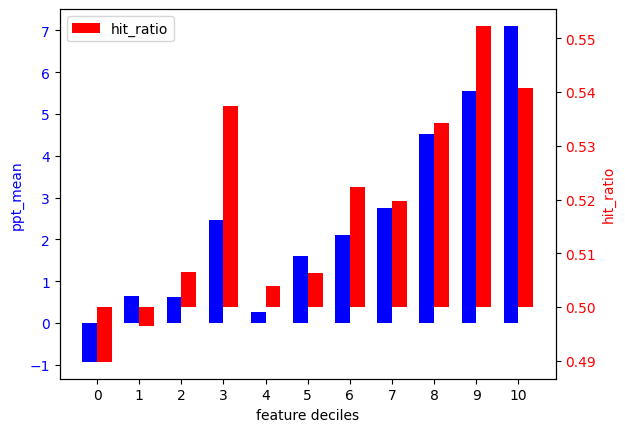

In [30]:
plot_grouped_statistics(get_group(df, '_250us_notional_os_decile'))

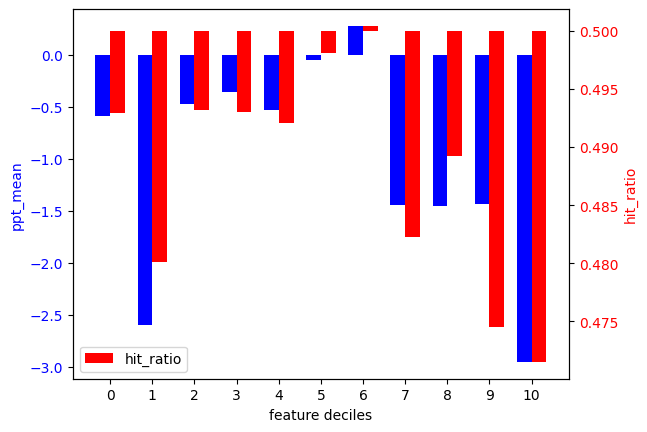

In [31]:
plot_grouped_statistics(get_group(df, '_250us_notional_ss_decile'))

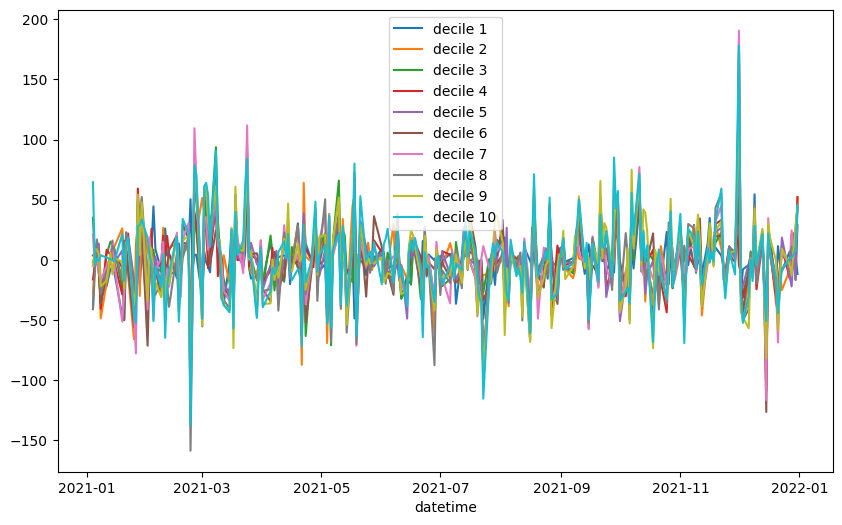

In [32]:
feature_name = '_250us_notional_os_decile'

fig, ax = plt.subplots(figsize=(10,6))

for i in range(1, 11):
    df.query(f'{feature_name} == {i}').groupby(lambda x: x.date()).pnl_to_close.mean().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

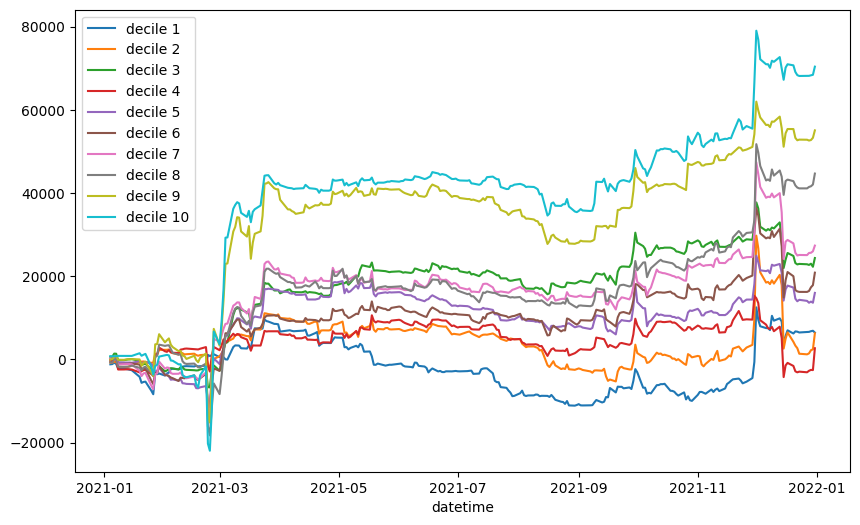

In [71]:
feature_name = '_250us_notional_os_decile'

fig, ax = plt.subplots(figsize=(10,6))

for i in range(1, 11):
    df.query(f'{feature_name} == {i}').groupby(lambda x: x.date()).pnl_to_close.sum().cumsum().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

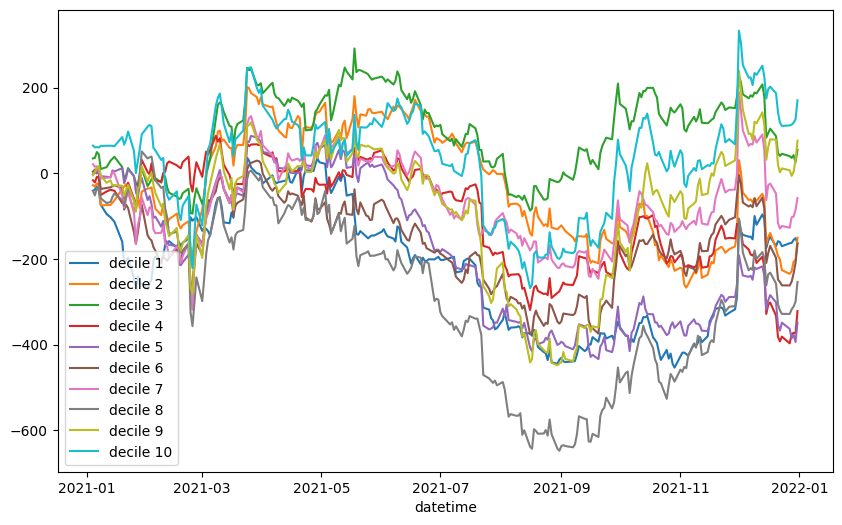

In [33]:
feature_name = '_250us_notional_os_decile'

fig, ax = plt.subplots(figsize=(10,6))

for i in range(1, 11):
    df.query(f'{feature_name} == {i}').groupby(lambda x: x.date()).pnl_to_close.mean().cumsum().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

In [34]:
for i in range(1, 11):
    sharpe = df.query(f'{feature_name} == {i}').pnl_to_close.mean() / df.query(f'{feature_name} == {i}').pnl_to_close.std()
    print(f"sharpe for decile {i}: {sharpe}")

sharpe for decile 1: 0.01131299019947174
sharpe for decile 2: 0.010575027888550928
sharpe for decile 3: 0.040854689142390745
sharpe for decile 4: 0.004544291490442815


sharpe for decile 5: 0.027448700970349613
sharpe for decile 6: 0.03433001638137391
sharpe for decile 7: 0.04454075665938627
sharpe for decile 8: 0.07699561228596234
sharpe for decile 9: 0.09154139206805635
sharpe for decile 10: 0.1163105720546142


In [35]:
# TODO: denoise by suctracting SPOOS return

<Axes: title={'center': 'Average PNL (bps) by Day'}>

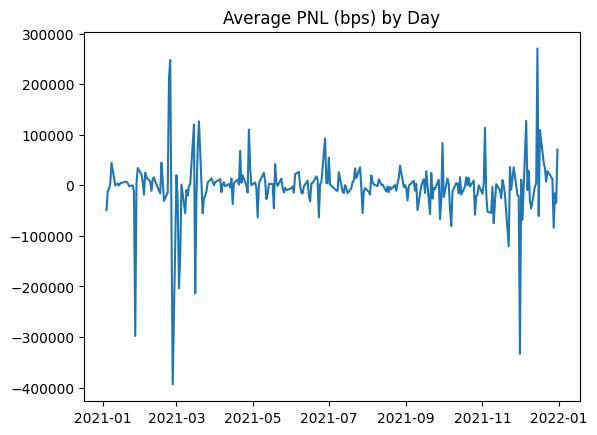

In [36]:
df_grouped = df.groupby(df.index.date)['pnl_to_close'].sum()
df_grouped.plot(title='Average PNL (bps) by Day')

In [37]:
df_grouped[df_grouped > 200_000]

2021-02-23    210520.562122
2021-02-24    247849.271511
2021-12-15    270619.406684
Name: pnl_to_close, dtype: float64

In [38]:
df_grouped[df_grouped < -200_000]

2021-01-27   -297916.178854
2021-02-26   -393937.111535
2021-03-03   -203526.073030
2021-03-16   -213817.381550
2021-12-01   -333587.389163
Name: pnl_to_close, dtype: float64

#### 

OFI

In [39]:
def plot_count_histograms_per_tag(df, feature_name) -> None:
    X = pd.concat([df.query(f"{feature_name} == {i}").resample('5min').size() for i in range(0, 11)], axis=1).fillna(0)

    for column in X.columns:
        x = X[column]
        # filter non-iso
        x = x[x > 0]

        plt.figure(figsize=(3,2))
        plt.hist(x, bins=np.arange(x.min(), x.max()), density=True)

        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

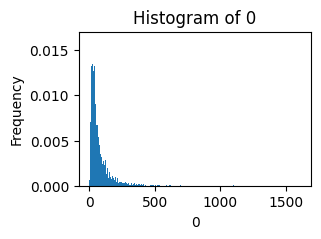

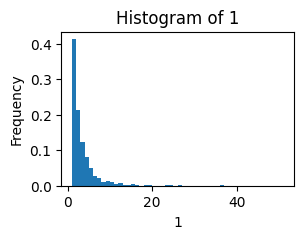

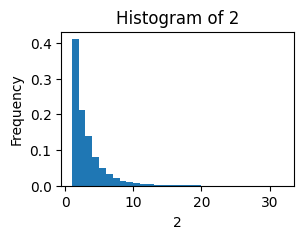

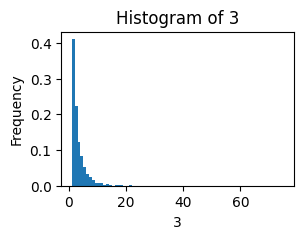

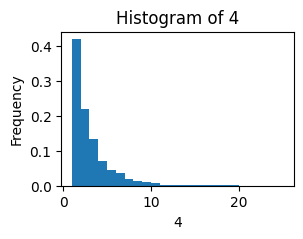

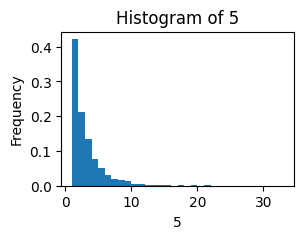

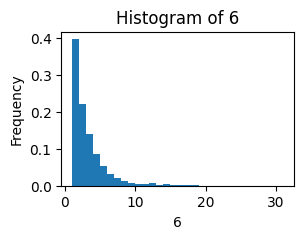

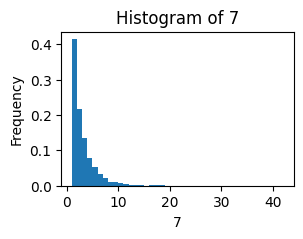

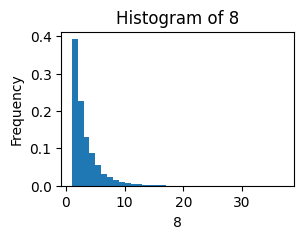

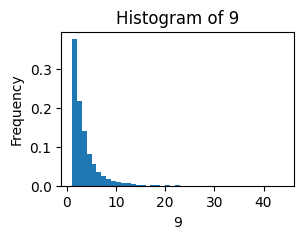

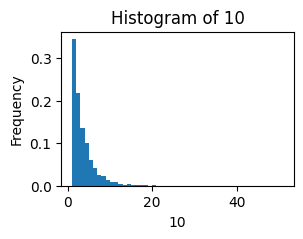

In [40]:
plot_count_histograms_per_tag(df, '_250us_notional_os_decile')

In [46]:
def compute_log_returns2(mid):
    zz = pd.DataFrame(mid)

    markouts_str = ["30S", "1min", "2min"]

    Markout = namedtuple('Markout', ['str','int'])
    markouts = [Markout(x, markout_to_int(x)) for x in markouts_str]
    for markout in markouts:
        zz[f"_{markout.str}"] = zz.mid.shift(-markout.int)

    logs = np.log(zz)

    logs = logs.resample('5min', label='right', closed='right').last()

    # not sure how to drop all resampled buckets where there was a NaN before
    # for now simply drop last row of resampled dataframe
    logs = logs.iloc[:-1]

    markouts_columns = logs.filter(regex="^_").columns.to_list()
    for markout_column in markouts_columns:
        logs[markout_column] = logs[markout_column] - logs['mid']
    # markouts_columns
    # markouts_columns = logs.filter(regex="^_").columns.to_list()
    # for markout_column in markouts_columns:
    #     logs[markout_column] = logs[markout_column] - logs['mid']
    logs['contemp'] = logs.mid - logs.mid.shift(1)

    logs.dropna(inplace=True)
    logs = logs.drop('mid', axis=1)
    return logs

In [43]:
compute_log_returns(df.mid)

,_30S,_1min,_2min,contemp
datetime,,,,
2021-01-04 09:40:00,-0.000519,-0.000445,-0.000519,-0.001631
2021-01-04 09:45:00,-0.000074,-0.000074,-0.000149,-0.002154
2021-01-04 09:50:00,-0.000074,-0.000074,-0.000149,0.000297
2021-01-04 09:55:00,0.000670,0.000670,0.000596,-0.001934
2021-01-04 10:00:00,0.000075,0.000075,0.000075,-0.001640
...,...,...,...,...
2021-12-31 15:35:00,0.000064,0.000000,-0.000064,-0.001536
2021-12-31 15:40:00,-0.000064,-0.000064,0.000000,-0.000705
2021-12-31 15:45:00,-0.000064,-0.000064,-0.000064,0.000320


In [47]:
compute_log_returns2(df.mid)

,_30S,_1min,_2min,contemp
datetime,,,,
2021-01-04 09:40:00,-0.000519,-0.000445,-0.000519,-0.001631
2021-01-04 09:45:00,-0.000074,-0.000074,-0.000149,-0.002154
2021-01-04 09:50:00,-0.000074,-0.000074,-0.000149,0.000297
2021-01-04 09:55:00,0.000670,0.000670,0.000596,-0.001934
2021-01-04 10:00:00,0.000075,0.000075,0.000075,-0.001640
...,...,...,...,...
2021-12-31 15:35:00,0.000064,0.000000,-0.000064,-0.001536
2021-12-31 15:40:00,-0.000064,-0.000064,0.000000,-0.000705
2021-12-31 15:45:00,-0.000064,-0.000064,-0.000064,0.000320


In [48]:
X = pd.concat([compute_ofi(df.query(f"_250us_notional_os_decile == {i}")) for i in range(0, 11)], axis=1)
X = X.fillna(0) # for no order flow, set 0 OFI
X.columns = [f"_{i}" for i in  range(11)]

Y = compute_log_returns2(df.mid)
X, Y = restrict_common_index(X, Y)

run_regressions(X, Y)

,r2,coef,intercept
target_markout,,,
_30S,0.001811,"[2.200118744539078e-05, -3.6208686711013614e-0...",0.0
_1min,0.001893,"[2.6182811554683554e-05, -4.04457648403342e-06...",0.0
_2min,0.001680,"[2.9314378749474886e-05, -2.590898591698459e-0...",0.0
contemp,0.015981,"[-0.00025494788194808634, -3.750410431682322e-...",0.0


In [67]:
X = pd.concat([compute_ofi(df.query(f"_250us_notional_os_decile == {i}")) for i in range(0, 11)], axis=1)
X = X.fillna(0) # for no order flow, set 0 OFI
X.columns = [f"_{i}" for i in  range(11)]

Y = compute_log_returns2(df.mid)
X, Y = restrict_common_index(X, Y)

X = sm.add_constant(X)
# Y = Y.contemp
Y = Y._1min

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  _1min   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.193
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           0.000239
Time:                        14:28:56   Log-Likelihood:             1.0592e+05
No. Observations:               18426   AIC:                        -2.118e+05
Df Residuals:                   18414   BIC:                        -2.117e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.282e-06   7.42e-06      0.442      0.658   -1.13e-05    1.78e-05
_0          2.392e-05   1.51e-05      1.585      0.113   -5.66e-06    5.35e-05
_1         -3.565e-06   1.48e-05     -0.241      0.809   -3.25e-05    2.54e-05
_2         -3.361e-06   1.43e-05     -0.235      0.814   -3.14e-05    2.47e-05
_3         -2.284e-05   1.43e-05     -1.603      0.109   -5.08e-05     5.1e-06
_4           1.13e-05   1.41e-05      0.801      0.423   -1.64e-05    3.89e-05
_5          2.346e-05   1.41e-05      1.660      0.097   -4.24e-06    5.12e-05
_6         -3.896e-05   1.44e-05     -2.703      0.007   -6.72e-05   -1.07e-05
_7          3.936e-06   1.43e-05      0.275      0.783   -2.41e-05    3.19e-05
_8         -2.099e-05   1.46e-05     -1.438      0.151   -4.96e-05    7.63e-06
_9         -5.749e-05    1.5e-05     -3.832      0.000   -8.69e-05   -2.81e-05
_10         7.132e-06   1.56e-05      0.458      0.647   -2.34e-05    3.77e-05
==============================================================================
Omnibus:                     9515.212   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         56763414.673
Skew:                           0.621   Prob(JB):                         0.00
Kurtosis:                     274.907   Cond. No.                         3.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
def plot_ofi_histograms_per_tag(df, feature_name) -> None:
    X = pd.concat([compute_ofi(df.query(f"{feature_name} == {i}")) for i in range(0, 11)], axis=1)
    X = X.fillna(0) # for no order flow, set 0 OFI
    X.columns = [f"_{i}" for i in  range(11)]

    Y = compute_log_returns(df.mid)
    X, Y = restrict_common_index(X, Y)

    for column in X.columns:
        plt.figure(figsize=(3,2))
        plt.hist(X[column], bins=30, density=True)
        plt.title(f"Histogram of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()

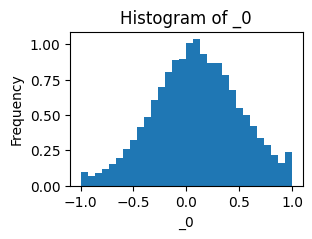

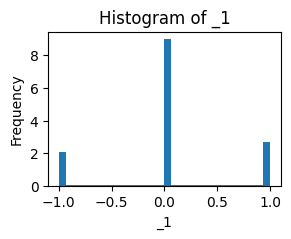

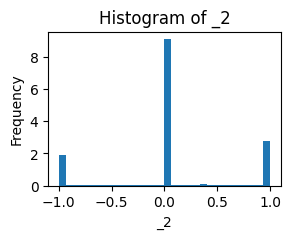

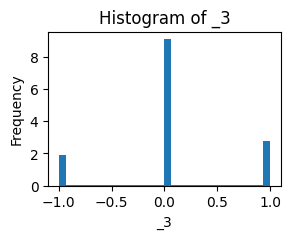

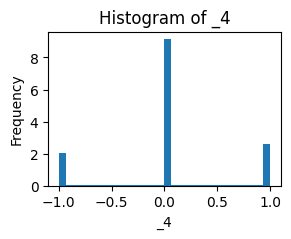

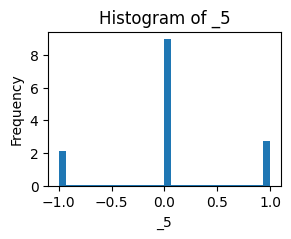

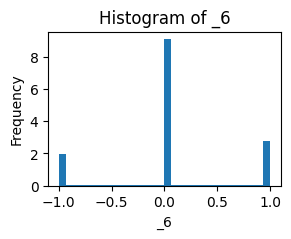

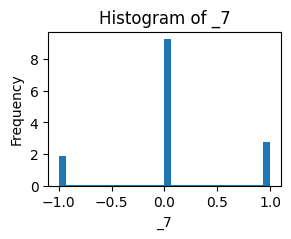

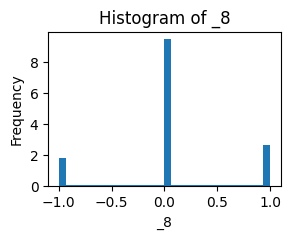

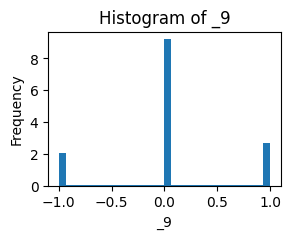

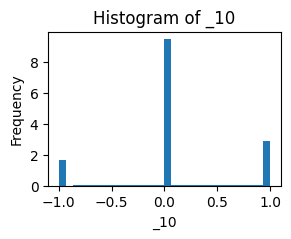

In [50]:
plot_ofi_histograms_per_tag(df, '_250us_notional_ss_decile')

In [68]:
# unconditional ofi
X = compute_ofi(df)
X = X.fillna(0) # for no order flow, set 0 OFI

Y = compute_log_returns2(df.mid)
X, Y = restrict_common_index(X, Y)

X = sm.add_constant(X)
# Y = Y.contemp
Y = Y._1min

model = sm.OLS(Y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  _1min   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.101
Date:                Tue, 21 Nov 2023   Prob (F-statistic):              0.294
Time:                        14:29:16   Log-Likelihood:             1.0590e+05
No. Observations:               18426   AIC:                        -2.118e+05
Df Residuals:                   18424   BIC:                        -2.118e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.898e-05   5.89e-06      3.222      0.001    7.43e-06    3.05e-05
ofi         1.606e-05   1.53e-05      1.049      0.294   -1.39e-05     4.6e-05
==============================================================================
Omnibus:                     9944.354   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         57145617.692
Skew:                           0.766   Prob(JB):                         0.00
Kurtosis:                     275.819   Cond. No.                         2.72
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Preliminary evidence groupby by quantile by year

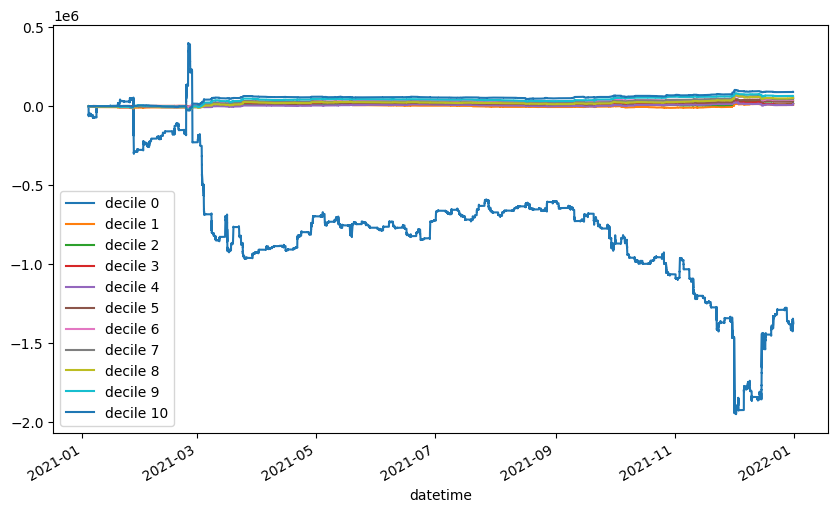

In [112]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(0, 11):
    df.query(f'_500us_notional_os_decile == {i}').pnl_to_close.cumsum().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

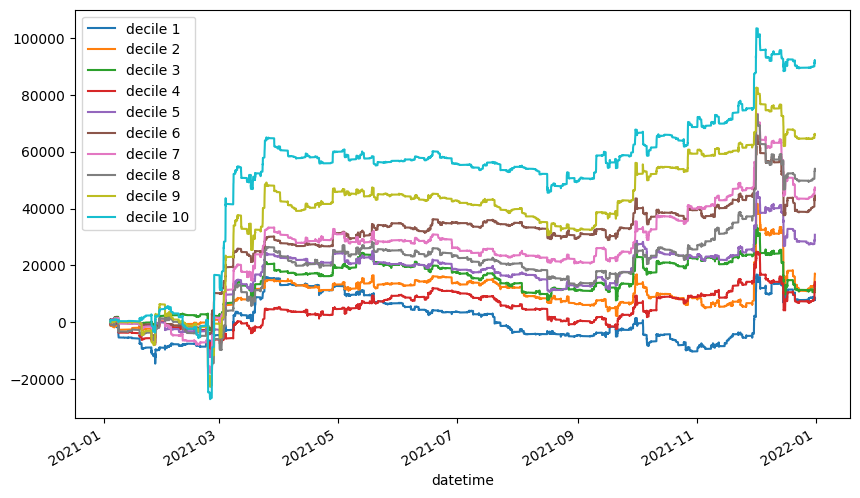

In [113]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(1, 11):
    df.query(f'_500us_notional_os_decile == {i}').pnl_to_close.cumsum().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

In [271]:
df.eval('ret = pnl_to_close / 1e4', inplace=True)

In [274]:
df1 = df.query(f'_500us_notional_os_decile == 10').ret.copy(deep=True)
daily_returns = df1.groupby(df1.index.date).mean()
daily_returns.mean() / daily_returns.std()

0.01860449561186662

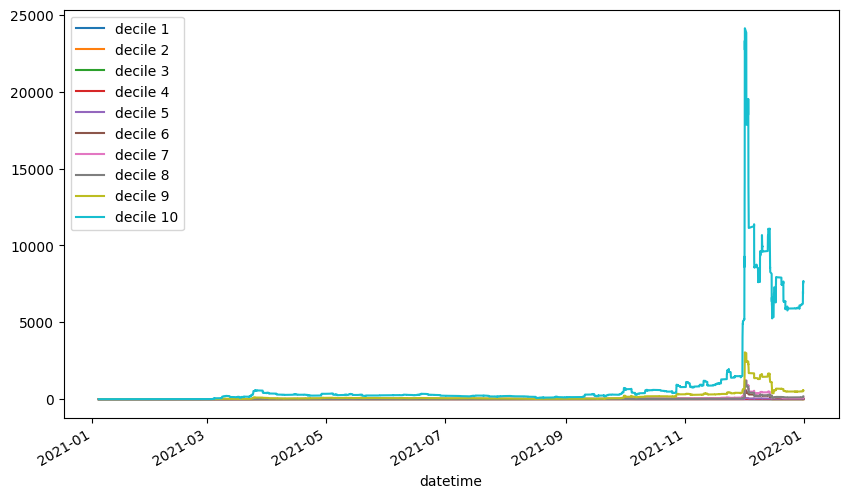

In [270]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(1, 11):
    df.query(f'_500us_notional_os_decile == {i}').ret.cumprod().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for i in range(1, 11):
    df.query(f'_500us_notional_os_decile == {i}').pnl_to_close.cumsum().plot(ax=ax, label=f'decile {i}')

plt.legend()
plt.show()

#### Sharpe

In [ ]:
df1 = df.query(f'_500us_notional_os_decile == 10').pnl_to_close.copy(deep=True)
daily_returns = df1.groupby(df1.index.date).mean()

In [164]:
df1 = df.query(f'_500us_notional_os_decile == 10').pnl_to_close.copy(deep=True)
daily_returns = df1.groupby(df1.index.date).mean()

In [165]:
daily_returns

2021-01-04    55.462690
2021-01-05    -6.151922
2021-01-06     3.395875
2021-01-07    -0.043274
2021-01-08   -12.136896
                ...    
2021-12-27     3.808475
2021-12-28     4.436923
2021-12-29     6.358496
2021-12-30     3.419003
2021-12-31    44.445922
Name: pnl_to_close, Length: 250, dtype: float64

In [166]:
daily_returns.mean() / daily_returns.std()

0.018604495611866625

#### OFIs

In [234]:
df.mid.resample('5min').last().shift(1)

datetime
2021-01-04 09:30:00       NaN
2021-01-04 09:35:00    67.505
2021-01-04 09:40:00    67.395
2021-01-04 09:45:00    67.250
2021-01-04 09:50:00    67.270
                        ...  
2021-12-31 15:35:00    78.050
2021-12-31 15:40:00    77.995
2021-12-31 15:45:00    78.020
2021-12-31 15:50:00    77.965
2021-12-31 15:55:00    77.705
Freq: 5T, Name: mid, Length: 104046, dtype: float64

In [232]:
df.mid.resample('5min').last()

datetime
2021-01-04 09:30:00    67.505
2021-01-04 09:35:00    67.395
2021-01-04 09:40:00    67.250
2021-01-04 09:45:00    67.270
2021-01-04 09:50:00    67.140
                        ...  
2021-12-31 15:35:00    77.995
2021-12-31 15:40:00    78.020
2021-12-31 15:45:00    77.965
2021-12-31 15:50:00    77.705
2021-12-31 15:55:00    77.685
Freq: 5T, Name: mid, Length: 104046, dtype: float64

In [229]:
Y

,_30S,_1min,_2min,contemp
datetime,,,,
2021-01-04 09:35:00,-0.000519,-0.000519,-0.000667,0.001631
2021-01-04 09:40:00,-0.000519,-0.000445,-0.000519,0.002154
2021-01-04 09:45:00,-0.000074,-0.000074,-0.000149,-0.000297
2021-01-04 09:50:00,-0.000074,-0.000074,-0.000149,0.001934
2021-01-04 09:55:00,0.000670,0.000670,0.000596,0.001640
...,...,...,...,...
2021-12-31 15:30:00,0.000000,0.000064,0.000128,0.001536
2021-12-31 15:35:00,0.000064,0.000000,-0.000064,0.000705
2021-12-31 15:40:00,-0.000064,-0.000064,0.000000,-0.000320


In [244]:
np.log(67.470) - np.log(67.360)

0.0016316847052628702

In [242]:
df.mid.resample('5min').first()

datetime
2021-01-04 09:30:00    67.695
2021-01-04 09:35:00    67.470
2021-01-04 09:40:00    67.360
2021-01-04 09:45:00    67.245
2021-01-04 09:50:00    67.265
                        ...  
2021-12-31 15:35:00    78.055
2021-12-31 15:40:00    77.990
2021-12-31 15:45:00    78.015
2021-12-31 15:50:00    77.965
2021-12-31 15:55:00    77.705
Freq: 5T, Name: mid, Length: 104046, dtype: float64

In [238]:
Y

,_30S,_1min,_2min,contemp
datetime,,,,
2021-01-04 09:40:00,-0.000519,-0.000445,-0.000519,-0.001631
2021-01-04 09:45:00,-0.000074,-0.000074,-0.000149,-0.002154
2021-01-04 09:50:00,-0.000074,-0.000074,-0.000149,0.000297
2021-01-04 09:55:00,0.000670,0.000670,0.000596,-0.001934
2021-01-04 10:00:00,0.000075,0.000075,0.000075,-0.001640
...,...,...,...,...
2021-12-31 15:35:00,0.000064,0.000000,-0.000064,-0.001536
2021-12-31 15:40:00,-0.000064,-0.000064,0.000000,-0.000705
2021-12-31 15:45:00,-0.000064,-0.000064,-0.000064,0.000320


In [256]:
X.sample(20)

,ofi
datetime,
2021-12-17 12:50:00,0.099842
2021-11-11 12:35:00,0.149293
2021-08-18 13:25:00,0.537679
2021-07-02 13:00:00,0.808090
2021-04-15 09:55:00,0.028968
2021-02-11 12:25:00,-0.518424
2021-04-29 13:35:00,0.471068
2021-05-06 12:30:00,-0.837211
2021-02-26 09:55:00,0.379111


In [257]:
X

,ofi
datetime,
2021-01-04 09:40:00,-0.215316
2021-01-04 09:45:00,0.181602
2021-01-04 09:50:00,-0.032230
2021-01-04 09:55:00,0.489251
2021-01-04 10:00:00,0.701882
...,...
2021-12-31 15:35:00,0.121631
2021-12-31 15:40:00,-0.351283
2021-12-31 15:45:00,-0.159085


In [260]:
X

,ofi
datetime,
2021-01-04 09:40:00,-0.215316
2021-01-04 09:45:00,0.181602
2021-01-04 09:50:00,-0.032230
2021-01-04 09:55:00,0.489251
2021-01-04 10:00:00,0.701882
...,...
2021-12-31 15:35:00,0.121631
2021-12-31 15:40:00,-0.351283
2021-12-31 15:45:00,-0.159085


In [259]:
X = compute_ofi(df)
X = pd.DataFrame(X) # tmp fix
Y = compute_log_returns(df.mid)
X, Y = restrict_common_index(X, Y)
# print(X)
# print(Y)
run_regressions(X, Y)

,r2,coef,intercept
target_markout,,,
_30S,-0.000536,[2.5592530391572006e-05],0.0
_1min,-0.000504,[2.881596606563757e-05],0.0
_2min,-0.000627,[3.1450230298814306e-05],0.0
contemp,0.014343,[-0.00029700015237814586],0.0


In [237]:
X = pd.concat([compute_ofi(df.query(f"_500us_notional_os_decile == {i}")) for i in range(0, 11)], axis=1)
X = X.fillna(0) # for no order flow, set 0 OFI
X.columns = range(11)

Y = compute_log_returns(df.mid)
X, Y = restrict_common_index(X, Y)

run_regressions(X, Y)

,r2,coef,intercept
target_markout,,,
_30S,0.001481,"[2.2768590911369735e-05, 2.9548178006308924e-0...",0.000006
_1min,0.001482,"[2.6745891593117772e-05, 2.889654969636313e-05...",0.000007
_2min,0.001649,"[2.6859770789570454e-05, 3.4577257730876217e-0...",0.000011
contemp,0.015877,"[-0.0002389747605278782, -3.221983993141733e-0...",-0.000004


In [210]:
X.columns = range(11)
run_regressions()

,0,1,2,3,4,5,6,7,8,9,10
datetime,,,,,,,,,,,
2021-01-04 09:35:00,-0.213995,-1.000000,-1.000000,NaN,1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN
2021-01-04 09:40:00,-0.088624,0.000000,0.000000,-0.600000,-1.000000,-1.000000,NaN,NaN,-1.000000,NaN,NaN
2021-01-04 09:45:00,0.208393,0.000000,1.000000,0.000000,1.000000,-1.000000,NaN,NaN,0.000000,NaN,-1.000000
2021-01-04 09:50:00,-0.152088,1.000000,0.000000,-1.000000,1.000000,0.000000,NaN,NaN,1.000000,NaN,0.000000
2021-01-04 09:55:00,0.489251,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 15:40:00,-0.170790,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-12-31 15:45:00,0.069259,-0.373041,-0.666667,-1.000000,-0.987780,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000
2021-12-31 15:50:00,0.131204,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,-0.985838,-1.000000,0.000000,0.000000


#### Old stuff

In [ ]:
QUANTILE = 0.95
col_name = "_500us_distinct_tickers"
col_name_clip = col_name + "_clip"


In [ ]:
df[col_name_clip] = df[col_name].clip(upper=df[col_name].quantile(QUANTILE))

In [ ]:
grouped_df = df[['hit_ratio', 'pnl_to_close', col_name_clip]].groupby(by=col_name_clip).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
df.columns

Index(['time', 'event', 'order_id', 'size', 'price', 'direction',
       'ask_price_1', 'bid_price_1', 'ticker', 'mid', '_250us_neighbors',
       '_500us_neighbors', '_250us_distinct_tickers_ss_bf',
       '_250us_distinct_tickers_ss_af', '_250us_distinct_tickers_os_bf',
       '_250us_distinct_tickers_os_af', '_250us_notional_ss_bf',
       '_250us_notional_ss_af', '_250us_notional_os_bf',
       '_250us_notional_os_af', '_250us_num_trades_ss_bf',
       '_250us_num_trades_ss_af', '_250us_num_trades_os_bf',
       '_250us_num_trades_os_af', '_500us_distinct_tickers_ss_bf',
       '_500us_distinct_tickers_ss_af', '_500us_distinct_tickers_os_bf',
       '_500us_distinct_tickers_os_af', '_500us_notional_ss_bf',
       '_500us_notional_ss_af', '_500us_notional_os_bf',
       '_500us_notional_os_af', '_500us_num_trades_ss_bf',
       '_500us_num_trades_ss_af', '_500us_num_trades_os_bf',
       '_500us_num_trades_os_af', 'pnl_to_close', 'hit_ratio',
       '_500us_distinct_tickers', '_500u

In [ ]:
grouped_df

,ppt_mean,ppt_std,hit_raio
_500us_distinct_tickers_clip,,,
0,-0.620705,62.241559,0.492495
1,-1.154729,60.229855,0.488880
2,-0.983373,59.119667,0.490208
3,-1.211530,61.456763,0.483649
4,0.284174,60.475169,0.499092


In [ ]:
grouped_df = df[['hit_ratio', 'pnl_to_close', col_name_clip]].groupby(by=col_name_clip).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
QUANTILE = 0.95
col_name = "_500us_num_trades"
col_name_clip = col_name + "_clip"

In [ ]:
df[col_name_clip] = df[col_name].clip(upper=df[col_name].quantile(QUANTILE))

In [ ]:
grouped_df = df[['hit_ratio', 'pnl_to_close', col_name_clip]].groupby(by=col_name_clip).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
grouped_df

,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_clip,,,
0,-0.620705,62.241559,0.492495
1,-0.951186,59.917935,0.490033
2,-0.552256,59.514261,0.496018
3,-0.552811,59.919713,0.492704
4,-1.243655,60.074425,0.485892
5,-0.166191,58.707417,0.499487
6,-0.618547,59.863505,0.488867
7,-0.146460,60.773337,0.501561
8,-0.332109,61.497333,0.477329


In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()